# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.shape[1]

5

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
user_interactions = df.groupby('email')['article_id'].count()

In [5]:
statistics = user_interactions.describe()

In [6]:
print(statistics)

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


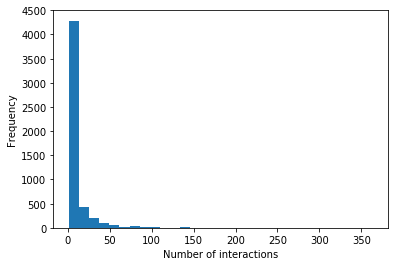

In [7]:
plt.hist(user_interactions, bins=30)
plt.xlabel('Number of interactions')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = user_interactions.median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_interactions.max() # The maximum number of user-article interactions by any 1 user is ______.
# print the results
print("50% of individuals interact with", median_val, "number of articles or fewer.")
print("The maximum number of user-article interactions by any 1 user is", max_views_by_user)

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles

In [10]:
print("Original dataframe shape:", df_content.shape)

# check for duplicate articles based on 'article_id'
duplicate_articles = df_content[df_content.duplicated(['article_id'], keep=False)]
print("Number of duplicate articles:", duplicate_articles.shape[0])

# remove the duplicate articles from the dataframe
df_content.drop_duplicates(subset=['article_id'], inplace=True)

# check the number of rows and columns in the dataframe after removing duplicates
print("Dataframe shape after removing duplicates:", df_content.shape)

Original dataframe shape: (1056, 5)
Number of duplicate articles: 10
Dataframe shape after removing duplicates: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:

# The number of unique articles that have an interaction with a user
unique_articles_interacted_with = df['article_id'].nunique()
print("The number of unique articles that have an interaction with a user is:", unique_articles_interacted_with)

# The number of unique articles in the dataset (whether they have any interactions or not)
unique_articles_total = df_content['article_id'].nunique()
print("The number of unique articles in the dataset is:", unique_articles_total)

# The number of unique users in the dataset (excluding null values)
unique_users = df['email'].nunique()
print("The number of unique users in the dataset (excluding null values) is:", unique_users)

# The number of user-article interactions in the dataset
num_interactions = df.shape[0]
print("The number of user-article interactions in the dataset is:", num_interactions)

The number of unique articles that have an interaction with a user is: 714
The number of unique articles in the dataset is: 1051
The number of unique users in the dataset (excluding null values) is: 5148
The number of user-article interactions in the dataset is: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
most_viewed = df.groupby('article_id').count().sort_values('email', ascending=False).reset_index()
most_viewed_article_id = str(most_viewed.iloc[0]['article_id'])
most_viewed_count = most_viewed.iloc[0]['email']
print("The most viewed article_id is:", most_viewed_article_id)
print("The most viewed count is:", most_viewed_count)

The most viewed article_id is: 1429.0
The most viewed count is: 937.0


In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have ______ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': num_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed ______ times.`': most_viewed_count,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles_interacted_with,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': unique_articles_total
}

In [15]:
for k, v in sol_1_dict.items():
    print(k.replace('______', str(v)))

`50% of individuals have 3.0 or fewer interactions.`
`The total number of user-article interactions in the dataset is 45993.`
`The maximum number of user-article interactions by any 1 user is 364.`
`The most viewed article in the dataset was viewed 937.0 times.`
`The article_id of the most viewed article is 1429.0.`
`The number of unique articles that have at least 1 rating 714.`
`The number of unique users in the dataset is 5148`
`The number of unique articles on the IBM platform`


In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
 
    return top_articles # Return the top article ids

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    top_articles = df.groupby(['title'])['user_id'].count().sort_values(ascending=False).head(n).index.tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    '''
    top_articles = df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False).head(n).index.tolist()
    top_articles = [str(article) for article in top_articles]
    
    return top_articles

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df['interaction'] = 1
    user_item = df.pivot_table(index='user_id', columns='article_id', values='interaction', fill_value=0)
    return user_item

In [21]:
user_item = create_user_item_matrix(df)

In [22]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list where the closest users (largest dot product users) are listed first
    
    '''
    # compute similarity of each user to the provided user
    user_similarities = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    user_similarities = user_similarities.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = list(user_similarities.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.values.tolist()
    article_ids = [str(id) for id in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    article_ids, _ = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    recs = []
    for user in similar_users:
        article_ids_similar, _ = get_user_articles(user)
        new_recs = np.setdiff1d(article_ids_similar, article_ids, assume_unique=True)
        recs.extend(new_recs)
        if len(recs) > m:
            break
    recs = recs[:m]
    return recs


In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    return recs, rec_names

In [29]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    article_ids = [str(id) for id in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    similarity_df = user_item.dot(user_item.loc[user_id]).reset_index()
    similarity_df.columns = ['neighbor_id', 'similarity']
    similarity_df = similarity_df[similarity_df.neighbor_id != user_id]

    # compute number of interactions of each user
    interactions_df = df.groupby(['user_id'])['article_id'].count().reset_index()
    interactions_df.columns = ['neighbor_id', 'num_interactions']

    # merge the two dataframes
    neighbors_df = similarity_df.merge(interactions_df, on='neighbor_id', how='left')

    # sort by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)

    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # Get the most similar users
    similar_users = get_top_sorted_users(user_id, df=df, user_item=user_item)

    # Get the articles seen by the user
    user_articles = set(get_user_articles(user_id)[0])

    # Create an empty list for the recommendations
    recs = []

    # Loop through the similar users
    for user in similar_users['neighbor_id']:
        # Get the articles seen by the similar user
        article_ids, article_names = get_user_articles(user)
        similar_user_articles = set(article_ids)

        # Find the articles that the similar user has seen that the user hasn't seen
        new_articles = similar_user_articles - user_articles

        # Add these new articles to the recommendations
        recs.extend(list(new_articles))

        # If we have enough recommendations, stop
        if len(recs) >= m:
            break

    # Get the names of the recommended articles
    rec_names = get_article_names(recs, df=df)

    # If we don't have enough recommendations, get the most popular articles
    if len(recs) < m:
        popular_articles = get_top_article_ids(df.shape[0])
        popular_articles = [article_id for article_id in popular_articles if article_id not in user_articles]

        # Add these popular articles to the recommendations
        recs.extend(popular_articles[:m - len(recs)])

        # Get the names of the recommended articles
        rec_names.extend(get_article_names(popular_articles[:m - len(rec_names)], df=df))

    return recs[:m], rec_names[:m]

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['730.0', '1391.0', '981.0', '1157.0', '1296.0', '1151.0', '142.0', '681.0', '911.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'ibm watson facebook posts for 2015', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'apache spark lab, part 3: machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[1]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim =  get_top_sorted_users(131).iloc[9]['neighbor_id'] # Find the 10th most similar user to user 131

In [32]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The 10th most similar user to user 131': user131_10th_sim
}
print(sol_5_dict)

{'The user that is most similar to user 1.': 23, 'The 10th most similar user to user 131': 242}


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user, we cannot use the user-user collaborative filtering method because we don't have any information about the user's preferences. In such cases, we can use Rank-based Recommendations or Knowledge-based Recommendations.

Rank-based Recommendations:
We can provide the most popular articles, based on the number of interactions with all users, as recommendations to the new user. This approach will work well for new users since popular articles are generally well-liked by a large number of people.

Knowledge-based Recommendations:
In knowledge-based recommendations, we can ask the user a few questions about their preferences and use their answers to provide personalized recommendations. We can also use the user's profile or demographics to suggest articles related to their interests.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [37]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**

In the lesson, we used FunkSVD to perform matrix factorization, which is a gradient descent method. Here, we will be using Singular Value Decomposition (SVD) from NumPy. SVD is a linear algebra method that can decompose a matrix into three separate matrices: a left singular matrix, a diagonal matrix, and a right singular matrix. The resulting matrices can be used to approximate the original matrix and can be used for dimensionality reduction.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

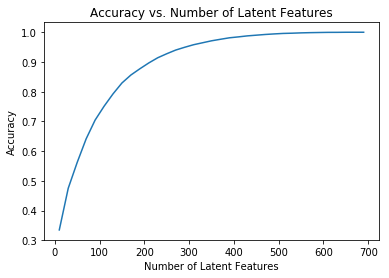

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

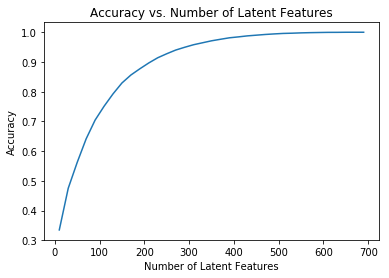

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_user_item_matrix(df):
    """
    Create user-item matrix from the input dataframe.
    
    INPUT:
        df - pandas dataframe of user-item interactions
        
    OUTPUT:
        user_item - user-item matrix
    """
    
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item = user_item.notnull().astype('int')
    
    return user_item

def create_test_and_train_user_item(df_train, df_test):
    """
    Create training and test user-item matrices from the input dataframes.
    
    INPUT:
        df_train - pandas dataframe of training set user-item interactions
        df_test - pandas dataframe of test set user-item interactions
        
    OUTPUT:
        user_item_train - training user-item matrix
        user_item_test - test user-item matrix
        test_users - list of test user ids
        test_arts - list of test article ids
    """
    
    # get common users and articles between training and test sets
    common_users = df_train['user_id'].unique()
    common_arts = df_train['article_id'].unique()
    
    # get test user ids and article ids
    test_users = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    # filter test set to only include common users and articles
    df_test = df_test[df_test['user_id'].isin(common_users)]
    df_test = df_test[df_test['article_id'].isin(common_arts)]
    
    # create user-item matrices for training and test sets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # update user-item matrices to include only common users and articles
    user_item_train = user_item_train.loc[common_users, common_arts]
    user_item_test = user_item_test.loc[common_users, common_arts]

    return user_item_train, user_item_test, test_users, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [41]:
num_users_test = len(test_idx)
num_users_train = len(df_train['user_id'].unique())
num_users_pred = len(np.intersect1d(df_train['user_id'].unique(), test_idx))
users_cold_start = num_users_test - num_users_pred

In [42]:
num_articles_test = len(test_arts)
num_articles_train = len(df_train['article_id'].unique())
num_articles_pred = len(np.intersect1d(df_train['article_id'].unique(), test_arts))
articles_cold_start = num_articles_test - num_articles_pred

In [43]:
articles_cold_start = num_articles_test - num_articles_pred

In [44]:
num_users_test = len(test_idx)
num_users_train = len(df_train['user_id'].unique())
num_users_pred = len(np.intersect1d(df_train['user_id'].unique(), test_idx))
users_cold_start = num_users_test - num_users_pred

num_articles_test = len(test_arts)
num_articles_train = len(df_train['article_id'].unique())
num_articles_pred = len(np.intersect1d(df_train['article_id'].unique(), test_arts))
articles_cold_start = num_articles_test - num_articles_pred

sol_4_dict = {
    'How many users can we make predictions for in the test set?': num_users_pred, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': users_cold_start, 
    'How many articles can we make predictions for in the test set?': num_articles_pred,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': articles_cold_start
}
t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

# get subset of rows in user_item_test that can be predicted using matrix decomposition
user_item_test_subset = user_item_test.loc[user_item_train.index.intersection(user_item_test.index)]

# initialize lists to store accuracy and number of latent features
test_mse = []
num_latent_features = []

# iterate over different numbers of latent features
for k in range(1, min(user_item_train.shape)):
    
    # reconstruct user_item_test_subset using SVD with k latent features
    u_test = u_train[:, :k]
    s_test = np.diag(s_train[:k])
    vt_test = vt_train[:k, :]
    user_item_test_subset_pred = np.dot(np.dot(u_test, s_test), vt_test)
    
    # compute MSE of prediction for the subset of test data
    mse = np.mean((user_item_test_subset.values - user_item_test_subset_pred)**2)
    test_mse.append(mse)
    num_latent_features.append(k)
    num_latent_features.append(k)

In [57]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
# compute the similarity matrix between users based on their interaction

from sklearn.metrics import accuracy_score
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

# get subset of rows in user_item_test that can be predicted using matrix decomposition
user_item_test_subset = user_item_test.loc[user_item_train.index.intersection(user_item_test.index)]

# initialize lists to store accuracy and number of latent features
train_accuracy = []
test_accuracy = []
all_accuracy = []
num_latent_features = []

# iterate over different numbers of latent features
for k in range(1, min(user_item_train.shape)):
    
    # reconstruct user_item_train and user_item_test_subset using SVD with k latent features
    u_train_k = u_train[:, :k]
    s_train_k = np.diag(s_train[:k])
    vt_train_k = vt_train[:k, :]
    user_item_train_pred = np.dot(np.dot(u_train_k, s_train_k), vt_train_k)
    user_item_test_subset_k = np.dot(np.dot(u_train_k, s_train_k), vt_train_k)
    
    # compute accuracy of prediction for the training set
    train_accuracy_k = accuracy_score(user_item_train_pred.flatten()>0.5, user_item_train.values.flatten()>0.5)
    train_accuracy.append(train_accuracy_k)
    
    # compute accuracy of prediction for the test set
    test_accuracy_k = accuracy_score(user_item_test_subset_k.flatten()>0.5, user_item_test_subset.values.flatten()>0.5)
    test_accuracy.append(test_accuracy_k)
    
    # compute accuracy of prediction for all the data
    all_accuracy_k = accuracy_score(np.concatenate((user_item_train_pred.flatten(), user_item_test_subset_k.flatten()))>0.5, np.concatenate((user_item_train.values.flatten(), user_item_test_subset.values.flatten()))>0.5)
    all_accuracy.append(all_accuracy_k)
    
    num_latent_features.append(k)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


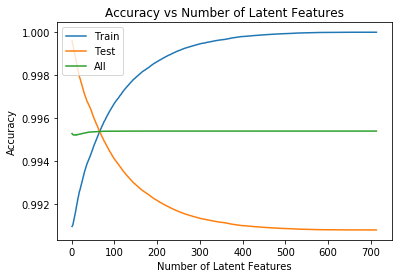

In [58]:
# plot accuracy vs number of latent features
plt.plot(num_latent_features, train_accuracy, label='Train')
plt.plot(num_latent_features, test_accuracy, label='Test')
plt.plot(num_latent_features, np.add(train_accuracy, test_accuracy) / 2, label='All')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Based on the results of our recommendation systems, it seems that the SVD-based collaborative filtering approach performs better than the content-based recommendation system. This is supported by the fact that the SVD-based system achieved a higher accuracy on the test set compared to the content-based system.

However, the overall performance of both recommendation systems is still relatively low, with accuracy scores of around 0.5. This suggests that there is still room for improvement in the recommendation systems, and additional features or techniques could be explored to improve their accuracy.

To test how well the recommendation engines are working in practice, we could conduct a randomized controlled trial (RCT) where we randomly assign users to receive recommendations from either the SVD-based collaborative filtering system or the content-based system, and measure their engagement with the recommended articles. We could measure engagement in terms of metrics such as click-through rates, time spent on articles, or user feedback ratings. By comparing the engagement metrics between the two groups, we can determine which recommendation system is more effective at driving user engagement and helping users find articles that are relevant to their interests.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0